## Variational inference in Dirichlet Process Normal Mixture

In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp
import DP_normal_mixture_opt_lib as dp_opt

from copy import deepcopy

from scipy import optimize

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [2]:
np.random.seed(3143)

# data parameters
num_obs = 1000 # number of observations 
x_dim = 2 # dimension of observations
k_true = 5 # true number of clusters

info_x = 0.3 * np.eye(x_dim) 

x, true_mu, true_z, true_pi = dp.draw_data(info_x, x_dim, k_true, num_obs)


# prior parameters
alpha = 2.0 # DP parameter
prior_mu = np.mean(x, axis = 0)
prior_info = 0.1 * np.eye(x_dim)

# variational truncation 
k_approx = 10 



observed mixture proportions: 
 [ 0.204  0.201  0.175  0.208  0.212]
true mixture proportions: 
 [ 0.2  0.2  0.2  0.2  0.2]


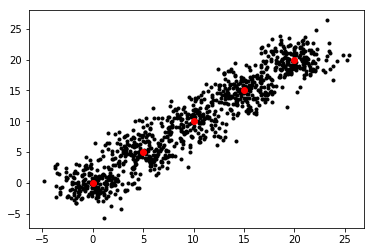

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_true):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

## Set up VB model

In [4]:
global_params = ModelParamsDict('global')
global_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)


In [5]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='prior_mu', size=x_dim, val=prior_mu))
prior_params.push_param(PosDefMatrixParam(name='prior_info', size=x_dim, val=prior_info))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

In [6]:
model = dp.DPNormalMixture(x, vb_params, prior_params)

## Initialize

In [7]:
## initialize VB params

true_init = False

if true_init: 
    true_tau = np.zeros(np.shape(vb_params['global']['v_sticks'].alpha.get()))
    true_tau[:,0] = true_v[:-1] * 100
    true_tau[:,1] = (1 - true_v[:-1]) * 100
    vb_params['global']['v_sticks'].alpha.set(true_tau)

    # vb_params['global']['mu'].set(true_mu)
    mu_size = vb_params['global']['mu'].free_size()
    vb_params['global']['mu'].set_free(np.random.random(mu_size))
    
    true_z_fudged = dp.soft_thresh(true_z, 1 - 10**(-8), 10**(-8))
    vb_params['local']['e_z'].set(true_z_fudged)
    # z_size = vb_params['local']['e_z'].free_size()
    # vb_params['local']['e_z'].set_free(np.random.random(z_size))
else: 
    vb_params.set_free(np.random.random(vb_params.free_size()))
    
init_par_vec = vb_params.get_free()
global_init_par_vec = vb_params['global'].get_free()

## Run CAVI 

max iteration reached


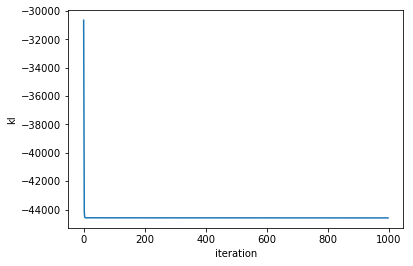

In [8]:
dp_opt.run_cavi(model, init_par_vec, max_iter = 1000, tol = 1e-8, disp = False)

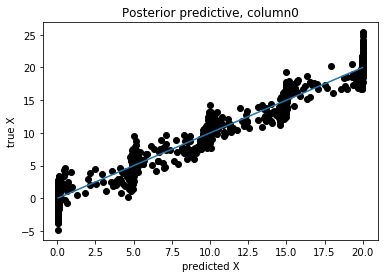

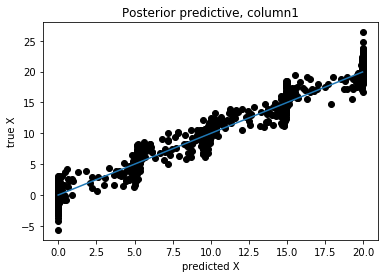

In [9]:
# plot posterior predictive
e_z = model.vb_params['local']['e_z'].get()
mu = model.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [10]:
# lets look at the estimated mixture proportions

tau = model.vb_params['global']['v_sticks'].alpha.get() 
post_stick_length = tau[:,0] / np.sum(tau, axis = 1) # mean posterior stick lengths

# compute mixture proportions using mean posterior stick lengths
post_pi = np.ones(k_approx)
stick_remain = np.ones(k_approx - 1)
for i in range(k_approx - 1):
    post_pi[i] = stick_remain[i - 1] * post_stick_length[i]
    stick_remain[i] = stick_remain[i - 1] * (1 - post_stick_length[i])
post_pi[-1] = stick_remain[-1]
assert(np.abs(np.sum(post_pi) - 1.) < 10**(-10))

print('true_proportions', true_pi)
print('estimated proportions: ', post_pi, '\n')

heavy_clusters = post_pi > 1 / k_approx # clusters with significant weights

print('true number of clusters: ', k_true)
print('number of posterior clusters (ie. no. clusters w/ siginifcant weights): ', np.sum(post_pi > 1 / k_approx))
print('recall variational truncation: ', k_approx)

true_proportions [ 0.2  0.2  0.2  0.2  0.2]
estimated proportions:  [ 0.00103921  0.19412396  0.02116628  0.03578555  0.00103388  0.20611839
  0.00103042  0.21146514  0.20226976  0.12596741] 

true number of clusters:  5
number of posterior clusters (ie. no. clusters w/ siginifcant weights):  5
recall variational truncation:  10


In [11]:
# lets look at posterior means
print('true means: ')
print(true_mu, '\n')

print('relevant posterior means (ie. posterior means for clusters with significant weights): ')
print(model.vb_params['global']['mu'].get()[heavy_clusters, :])

true means: 
[[ 0  0]
 [ 5  5]
 [10 10]
 [15 15]
 [20 20]] 

relevant posterior means (ie. posterior means for clusters with significant weights): 
[[  4.92487096e+00   5.10064299e+00]
 [  1.49640175e+01   1.49149320e+01]
 [  1.99868978e+01   1.99373496e+01]
 [  6.56468080e-02  -1.15699828e-02]
 [  9.86701027e+00   9.60510495e+00]]


In [12]:
cavi_results = deepcopy(model)

## Newton Optimization

In [13]:
kl_obj = Objective(model.vb_params['global'], model.kl_optimize_z)

In [14]:
def minimize_kl(kl_obj, init_x, maxiter = 50, gtol = 1e-8, disp = True):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hess=kl_obj.fun_free_hessian,
        method='trust-ncg', options={'maxiter': maxiter, 'gtol': gtol, 'disp': disp})

    print('done')
    return vb_opt

newton_tr_init = cavi_results.vb_params['global'].get_free() # initialize with result from CAVI
tr_opt = minimize_kl(kl_obj, newton_tr_init) # run Newton
print(kl_obj.fun_free(tr_opt.x))

Optimization terminated successfully.
         Current function value: -44593.213510
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4
         Hessian evaluations: 3
done
-44593.2135099


In [15]:
model.vb_params['global'].set_free(tr_opt.x)
model.set_optimal_z()

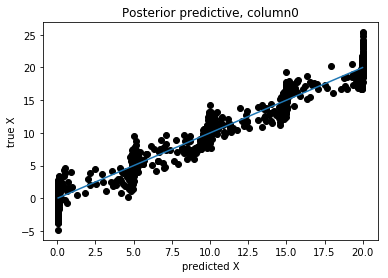

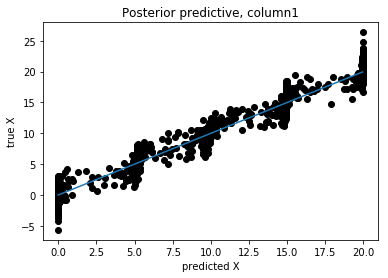

In [16]:
# plot posterior predictive
e_z = model.vb_params['local']['e_z'].get()
mu = model.vb_params['global']['mu'].get()
pred_x = np.dot(e_z, mu)
for col in range(x_dim):
    plt.clf()
    plt.plot(pred_x[:, col], x[:, col], 'ko')
    diag = np.linspace(np.min(pred_x[:,col]),np.max(pred_x[:,col]))
    plt.plot(diag, diag)
    plt.title('Posterior predictive, column' + str(col))
    plt.xlabel('predicted X')
    plt.ylabel('true X')
    plt.show()


In [17]:
# compare CAVI with Newton_tr
print(cavi_results.vb_params['global']['mu'].get())
print(model.vb_params['global']['mu'].get())

print('l1 difference between means: ', \
      np.sum(np.abs(cavi_results.vb_params['global']['mu'].get() - model.vb_params['global']['mu'].get())))

[[  1.01031277e+01   1.01279437e+01]
 [  4.92487096e+00   5.10064299e+00]
 [  7.31465901e+00   8.98293819e+00]
 [  1.09754607e+01   1.16809368e+01]
 [  1.01031286e+01   1.01279366e+01]
 [  1.49640175e+01   1.49149320e+01]
 [  1.01031292e+01   1.01279320e+01]
 [  1.99868978e+01   1.99373496e+01]
 [  6.56468080e-02  -1.15699828e-02]
 [  9.86701027e+00   9.60510495e+00]]
[[  1.01031295e+01   1.01279527e+01]
 [  4.92489568e+00   5.10059582e+00]
 [  7.31584409e+00   8.98171779e+00]
 [  1.09780919e+01   1.16852484e+01]
 [  1.01031304e+01   1.01279455e+01]
 [  1.49639807e+01   1.49148974e+01]
 [  1.01031310e+01   1.01279409e+01]
 [  1.99868923e+01   1.99373443e+01]
 [  6.56454229e-02  -1.15687347e-02]
 [  9.86836642e+00   9.60723036e+00]]
l1 difference between means:  0.0130187534966


In [21]:
print('l1 difference (normalized) between all params: ', \
      np.mean(np.abs(cavi_results.vb_params.get_free() - model.vb_params.get_free())))

l1 difference (normalized) between all params:  0.00265479259298
